In [ ]:
# Basic imports (kept minimal)
import pandas as pd
import numpy as np
from pathlib import Path

# Set your paths
DATA_PATH = Path("kidney_disease_dataset.csv")



In [ ]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

# Keep an untouched copy for reference if needed
df_raw = df.copy()

# Quick sanity check (light)
print("Shape:", df.shape)
df.head()


Shape: (972, 10)


,Patient_ID,Age,Gender,Serum_Creatinine,Blood_Pressure,Diabetes,Days_In_Hospital,Received_Treatment,City,Deaths
0,1,57,Female,0.7,134,0,9,0,Pune,1
1,2,79,Female,0.7,143,0,19,1,Mumbai,1
2,3,77,Male,0.9,133,0,1,0,Pune,1
3,4,67,Female,1.7,117,0,10,0,Kolkata,1
4,5,90,Male,0.9,149,1,7,0,Ahmedabad,1


In [ ]:
# Clean column names: strip spaces, remove punctuation, snake_case, lowercase
df.columns = (
    df.columns
      .str.strip()
      .str.replace(r"[^\w\s]", "", regex=True)
      .str.replace(r"\s+", "_", regex=True)
      .str.lower()
)

df.columns.tolist()


['patient_id',
 'age',
 'gender',
 'serum_creatinine',
 'blood_pressure',
 'diabetes',
 'days_in_hospital',
 'received_treatment',
 'city',
 'deaths']

In [ ]:
# Turn common "null-like" placeholders into real NaN
NULL_LIKE = {"", "na", "n/a", "null", "none", "NaN", "?", "NA", "N/A", "NULL", "None"}

for col in df.columns:
    if df[col].dtype == "O":
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace({v: np.nan for v in NULL_LIKE}, regex=False)

# Quick missingness check (basic)
missing_basic = df.isna().sum().sort_values(ascending=False)
missing_basic[missing_basic > 0].head(20)


,0


In [ ]:
# Remove perfect duplicate rows (kept simple)
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before - after} duplicate rows. New shape: {df.shape}")


Removed 0 duplicate rows. New shape: (972, 10)


In [ ]:
# Keeps things safe and basic; avoids over-aggressive casting.

def looks_numeric(s: pd.Series, thresh: float = 0.7) -> bool:
    # Remove commas/% and test pattern
    ser = (
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("%", "", regex=False)
         .str.strip()
    )
    mask = ser.str.match(r"^-?\d+(\.\d+)?$", na=False)
    return mask.mean() >= thresh

for col in df.columns:
    if df[col].dtype == "O" and looks_numeric(df[col]):
        ser = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("%", "", regex=False)
            .str.extract(r"(-?\d+\.?\d*)", expand=False)
        )
        df[col] = pd.to_numeric(ser, errors="coerce")

df.dtypes


,0
patient_id,int64
age,int64
gender,object
serum_creatinine,float64
blood_pressure,int64
diabetes,int64
days_in_hospital,int64
received_treatment,int64
city,object
deaths,int64


In [ ]:
# Identify numeric vs categorical after coercion
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Median impute numerics
for col in num_cols:
    if df[col].isna().any():
        med = df[col].median()
        df[col] = df[col].fillna(med)

# Mode impute categoricals
for col in cat_cols:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else "Missing"
        df[col] = df[col].fillna(mode_val)

# Quick check that no NaNs remain.
df.isna().sum().sum()


np.int64(0)

In [ ]:
# Basic structure
print("Dataset shape:", df.shape)
df.info()


Dataset shape: (972, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          972 non-null    int64  
 1   age                 972 non-null    int64  
 2   gender              972 non-null    object 
 3   serum_creatinine    972 non-null    float64
 4   blood_pressure      972 non-null    int64  
 5   diabetes            972 non-null    int64  
 6   days_in_hospital    972 non-null    int64  
 7   received_treatment  972 non-null    int64  
 8   city                972 non-null    object 
 9   deaths              972 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 76.1+ KB


In [ ]:
# Summary statistics for numeric features
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
patient_id,972.0,486.500000,280.736531,1.0,243.75,486.5,729.25,972.0
age,972.0,54.263374,21.146017,18.0,35.00,55.5,72.00,90.0
serum_creatinine,972.0,1.754527,0.723128,0.5,1.10,1.7,2.40,3.0
blood_pressure,972.0,130.396091,29.257135,80.0,106.00,130.0,156.00,180.0
diabetes,972.0,0.336420,0.472728,0.0,0.00,0.0,1.00,1.0
days_in_hospital,972.0,10.621399,5.674366,1.0,6.00,10.0,16.00,20.0
received_treatment,972.0,0.295267,0.456398,0.0,0.00,0.0,1.00,1.0
deaths,972.0,0.842593,0.364372,0.0,1.00,1.0,1.00,1.0


In [ ]:
# Top value counts for categorical features
for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False).head(10))



--- gender ---
gender
Male      490
Female    482
Name: count, dtype: int64

--- city ---
city
Kolkata      130
Bengaluru    127
Delhi        125
Pune         125
Chennai      124
Mumbai       123
Ahmedabad    123
Hyderabad     95
Name: count, dtype: int64


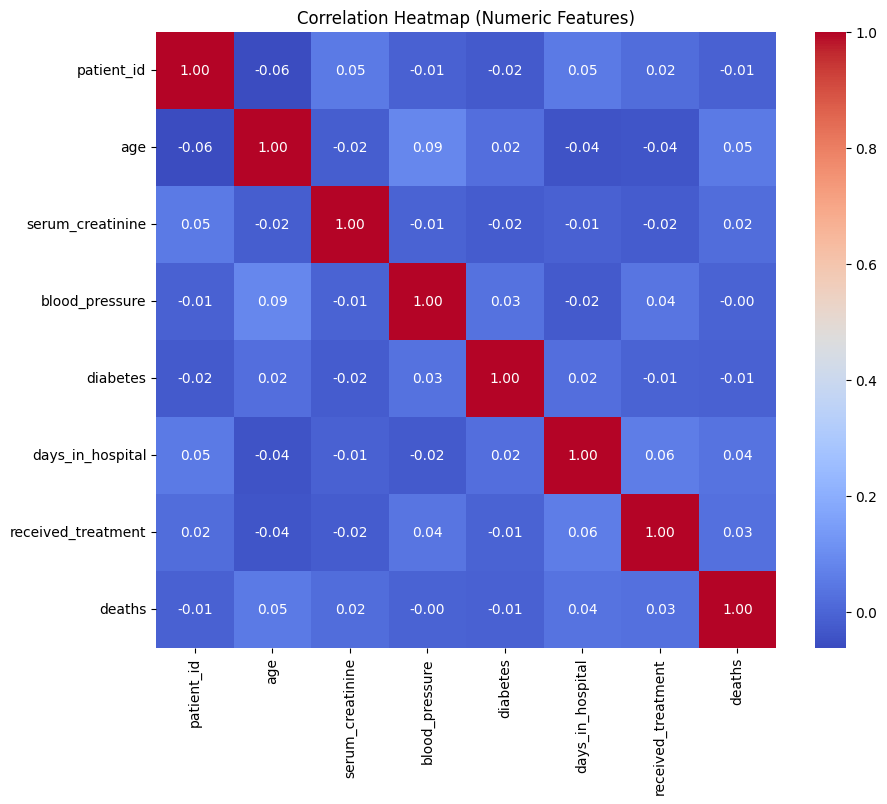

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


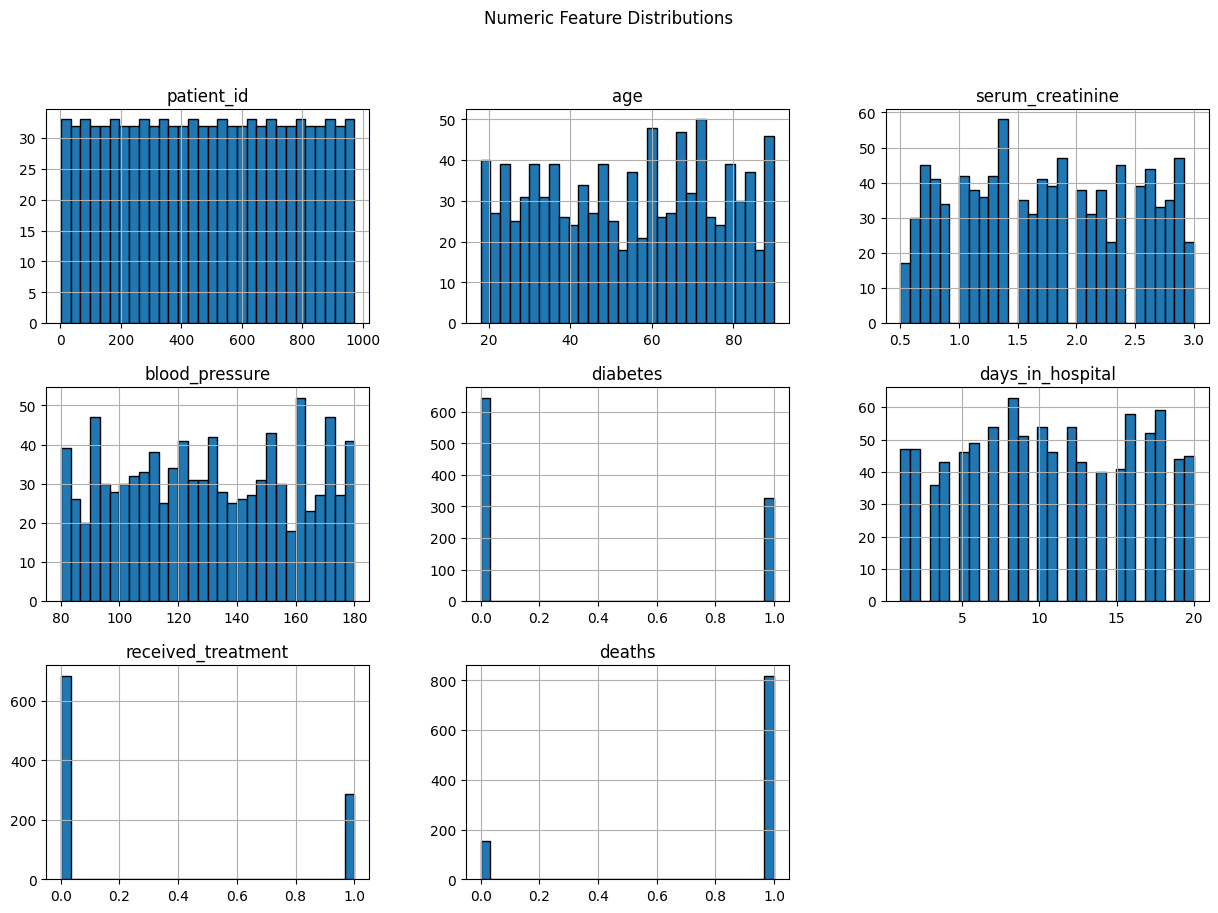

In [ ]:
# Distribution of numeric columns
df[num_cols].hist(figsize=(15, 10), bins=30, edgecolor="black")
plt.suptitle("Numeric Feature Distributions")
plt.show()


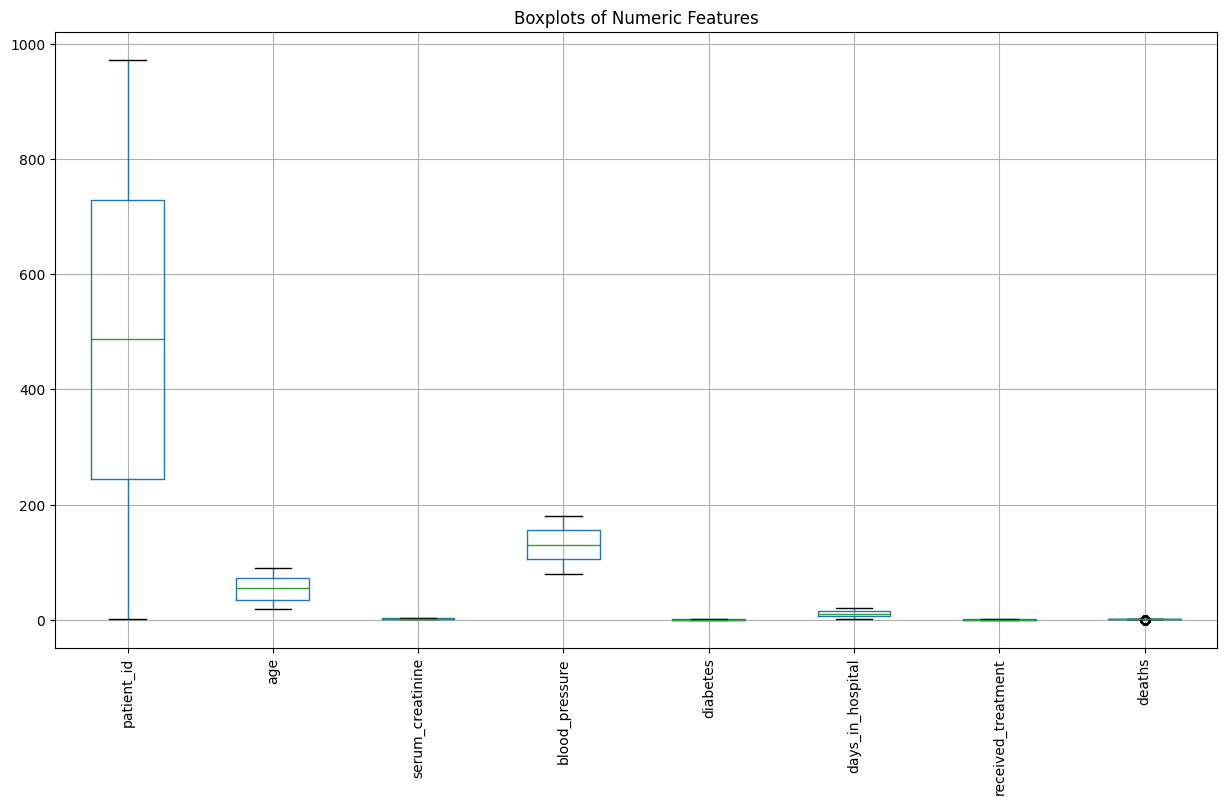

In [ ]:
# Boxplots for numeric features
plt.figure(figsize=(15, 8))
df[num_cols].boxplot(rot=90)
plt.title("Boxplots of Numeric Features")
plt.show()


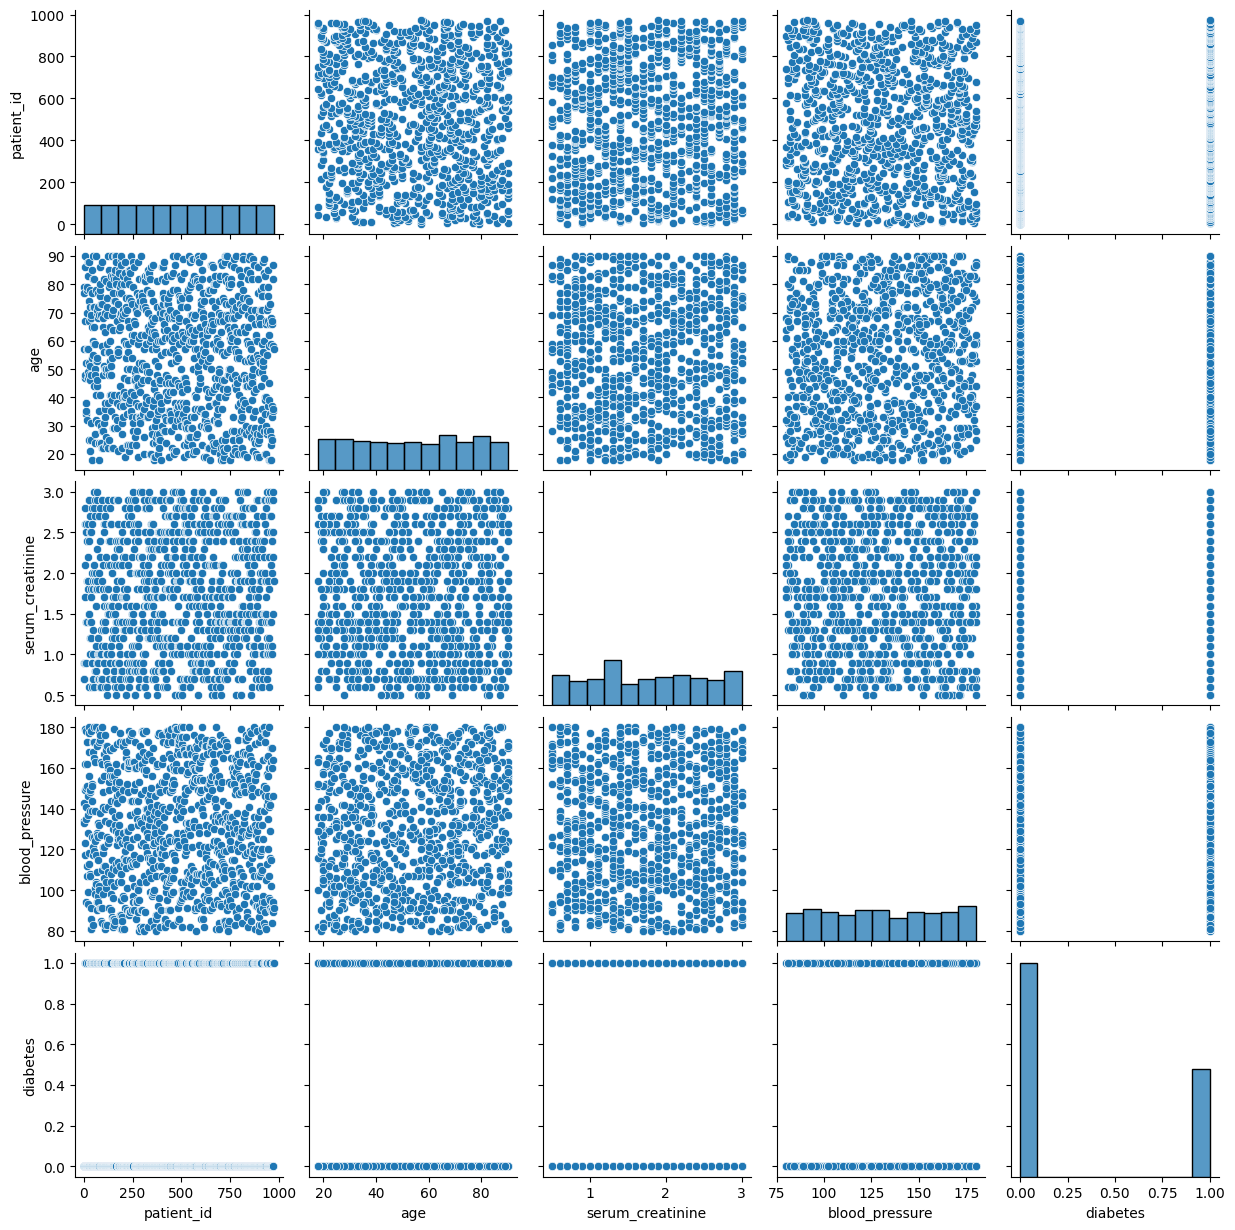

In [ ]:
# pairplot
sns.pairplot(df[num_cols[:5]])
plt.show()


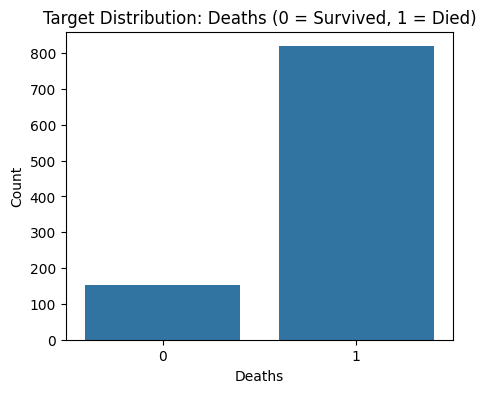

Counts:
 deaths
1    819
0    153
Name: count, dtype: int64
Percentages:
 deaths
1    84.259259
0    15.740741
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Binary target: 0 = no death, 1 = death
y = (df["deaths"] > 0).astype(int)

plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Target Distribution: Deaths (0 = Survived, 1 = Died)")
plt.xlabel("Deaths")
plt.ylabel("Count")
plt.show()

print("Counts:\n", y.value_counts())
print("Percentages:\n", y.value_counts(normalize=True) * 100)
